# Homework 7 Template

Rixin Li & G . Besla



In [ ]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [27]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from modded_COM import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [101]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, outfile): # **** add inputs
        """ 
        Class designed to calculate the analytic orbit of M33 around M31. 
        This class utilizes a Hernquist profile, and a Miyamoto Nagai acceleration
        to calculate accelerations of different galactic components, so that a 
        leapfrog solver can work out the motion equation.

        Inputs:
        -----
            outfile: str
                the file that will store the analytically solved orbit using leapfrog scheme
        Outputs:
        ----- 
            no outputs, just the created text file if OrbitIntegration is called
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename = outfile #will be given a name later

        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        COM_M33 = CenterOfMass('M33_000.txt', 2)
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        delta = 0.1 #the tolerance level for our COM calculation method
        volDec = 2 #typical shrinking method amount
        volDec_M33 = 4 #special shrinking for M33 due to tidal stripping
        COM_M33_pos = COM_M33.COM_P(delta, volDec_M33).value
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        COM_M33_vel = COM_M33.COM_V(COM_M33_pos[0]*u.kpc, COM_M33_pos[1]*u.kpc, COM_M33_pos[2]*u.kpc).value
        #because COM_V has units, we need to reassign u.kpc for the COM function temporarily
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        COM_M31 = CenterOfMass('M31_000.txt', 2)
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        COM_M31_pos = COM_M31.COM_P(delta, volDec).value
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        COM_M31_vel = COM_M31.COM_V(COM_M31_pos[0]*u.kpc, COM_M31_pos[1]*u.kpc, COM_M31_pos[2]*u.kpc).value
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = np.array([COM_M33_pos[0] - COM_M31_pos[0], COM_M33_pos[1] - COM_M31_pos[1], COM_M33_pos[2] - COM_M31_pos[2]])
        self.v0 = np.array([COM_M33_vel[0] - COM_M31_vel[0], COM_M33_vel[1] - COM_M31_vel[1], COM_M33_vel[2] - COM_M31_vel[2]])
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass('M31_000.txt', 2) * 10**12
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass('M31_000.txt', 3) * 10**12
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 60 #60 was my guess from HW5
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass('M31_000.txt', 1) * 10**12
    
    
    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """
        This function finds the Hernquist Acceleration of the bulge and halo, which is important for
        the leapfrog solver because we need total acceleration from all galactic components

        Inputs:
        -----
            M: float (not astropy quantity)
                Mass of either bulge or halo component, with units of Msun
            r_a: float
                scale length of bulge or halo component, with units of kpc
            r: numpy array
                array of position vector to find the acceleration at the position
        Outputs:
        -----
            Hern: numpy array
                3d vector array representing the acceleration components of the bulge or halo
        """
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2) 
        
        ### *** Store the Acceleration
        Hern =  np.array([-self.G* M / (rmag*(r_a+rmag)**2) * r[0], -self.G * M / (rmag*(r_a+rmag)**2) * r[1], 
        -self.G * M / (rmag*(r_a+rmag)**2) * r[2]]) #follow the formula in the HW instructions


        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r): # it is easiest if you take as an input a position VECTOR  r 
        """
        This function finds the Nagai Acceleration of the disk, which is important for
        the leapfrog solver because we need total acceleration from all galactic components

        Inputs:
        -----
            M: float 
                Mass of either disk component, with units of Msun
            r_a: float
                scale length of disk component, with units of kpc
            r: numpy array
                array of position vector to find the Nagai acceleration at the disk COM position 
        Outputs:
        -----
            nagai_accel: numpy array
                3d vector array representing the acceleration components of the disk according to the Nagai acceleration
        """

        #nagai_accel = coefficient * np.array([r[0], r[1], r[2] * B/(np.sqrt(r[2]**2 + (self.rdisk/5)**2))])

        
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction

        R = np.sqrt(r[0]**2 + r[1]**2)
        B = r_d + np.sqrt(r[2]**2 + (self.rdisk/5)**2)

        vector  = -self.G * M / (R**2 + B**2)**(1.5) * r

        ZSTUFF = B/(np.sqrt(r[2]**2 + (self.rdisk/5)**2))

        nagai_accel = vector * np.array([1,1,ZSTUFF])
        
       
        return nagai_accel
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """
        This function finds the total Acceleration of the disk, bulge, and halo, which is important for
        the leapfrog solver because we need total acceleration from all galactic components

        Inputs:
        -----
            r: numpy array
                array of position vector to find the total acceleration of the galaxy
        Outputs:
        -----
            tot_accel: numpy array
                3d vector array representing the acceleration components of the whole galaxy
        """
        disk_accel = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r) #disk uses Nagai Acceleration
        bulge_accel = self.HernquistAccel(self.Mbulge, self.rbulge, r) #bulge uses Hernquist Acceleration
        halo_accel = self.HernquistAccel(self.Mhalo, self.rhalo, r) #halo uses Hernquist Acceleration

        tot_accel = disk_accel + bulge_accel + halo_accel #sum each component

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
            
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return tot_accel
    
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        This function employs a numerical differential equation solver using Euler steps, 
        in order to solve the classical motion equation for objects influenced by gravity

        Inputs:
        -----
            dt: float 
                step size of leapfrog solver, to find new positions and velocites after some time has passed
            r: numpy array
                array of position vector in order to progress and solve the next position vector
            v: numpy array
                array of velocity vector in order to progress and solve the next velocity vector
        Outputs:
        -----
            rnew: numpy array
                array representing new position vector after leapfrog progression
            vnew: numpy array
                array representing new velocity vector after leapfrog progression
            
        """

        
        # predict the position at the next half timestep
        rhalf = r + (v * dt/2)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        #rnew = r + 0.5*(v + vnew) * dt
        rnew = rhalf + (vnew * dt/2)
        
        return rnew, vnew # **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        This function employs the leapfrog step and loops through it from a start time to an end time,
        taking tmax/dt number of steps to trace out the orbit of the two galaxies based on their initial positions and velocities.

        Inputs:
        -----
            t0: float 
                initial time corresponding to the initial positions and velocities
            dt: float
                step size for the leapfrog solver. Smaller dts will give a more complete orbit picture
            tmax: float
                Final time for the solver to reach
        Outputs:
        -----
            a txt file of the orbit positions and velocities as solved by the numerical solver,
            at incrimental times through t0 to tmax
            
        """

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        r = self.r0 #initialize orbit positions
        v = self.v0 #initialize orbit velocities
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t += dt
            # **** store the new time in the first column of the ith row
            orbit[i, 0] = t
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            r, v = self.LeapFrog(dt, r, v) #old r, v becomes new r, v
         
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8

            orbit[i, 1:4] = r
            orbit[i, 4:7] = v
            
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # could try orbit[i] = t, *tuple(r), *tuple(v)
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
        
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        
        

In [102]:
Orbit = M33AnalyticOrbit('integrated_orbit.txt')
Orbit.OrbitIntegration(0, 0.1, 10)


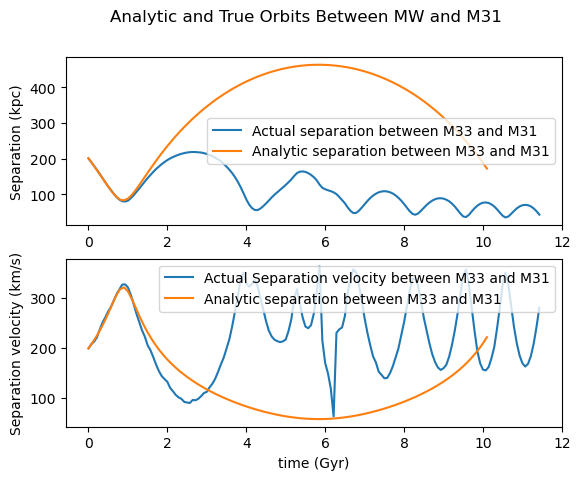

In [104]:
M33_M31_separations = np.array([]) #will be filled in with separation distances between M33 and M31
M33_M31_vel_separations = np.array([]) #will be filled in with relative velocity between M33 and M31
M31_orbit_data = np.genfromtxt("OrbitM31_0_800.txt",dtype=None,names=True,skip_header=0) #reading in COM data evolution for M31
M33_orbit_data = np.genfromtxt("OrbitM33_0_800.txt",dtype=None,names=True,skip_header=0) #reading in COM data evolution for M33
time_list = M33_orbit_data['t']

def separation(x1,x2,y1,y2,z1,z2):
    """
    function that calculates the distance between two vectors

    inputs:
        x1,x2,x3,y1,y2,y3: floats
            components of two vectors to be plugged into equation
    outputs:
        the magnitude of distance between the two vectors in 3d space
    """
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) #typical distance formula for 3d space
    #could make this n-dimensional but not needed for this problem

for i in range(0, len(M33_orbit_data['x'])):
    M33_M31_separations = np.append(M33_M31_separations, separation(M33_orbit_data['x'][i], M31_orbit_data['x'][i], 
    M33_orbit_data['y'][i], M31_orbit_data['y'][i], M33_orbit_data['z'][i], M31_orbit_data['z'][i]))

    M33_M31_vel_separations = np.append(M33_M31_vel_separations, separation(M33_orbit_data['vx'][i], M31_orbit_data['vx'][i], 
    M33_orbit_data['vy'][i], M31_orbit_data['vy'][i], M33_orbit_data['vz'][i], M31_orbit_data['vz'][i]))

analytic_orbit = np.genfromtxt("integrated_orbit.txt",dtype=None,names=True,skip_header=0) #reading in analytic evolution for M33-M31 as solved by leapfrog
analytic_time = analytic_orbit['t']

analytic_separation_list = np.array([])
analytic_velocity_list = np.array([])
for i in range(0, len(analytic_orbit['x'])):
    analytic_separation_list = np.append(analytic_separation_list, np.sqrt(analytic_orbit['x'][i]**2 + analytic_orbit['y'][i]**2 +analytic_orbit['z'][i]**2))
    analytic_velocity_list = np.append(analytic_velocity_list, np.sqrt(analytic_orbit['vx'][i]**2 + analytic_orbit['vy'][i]**2 +analytic_orbit['vz'][i]**2))

fig, (ax1, ax2) = plt.subplots(2) 
fig.suptitle('Analytic and True Orbits Between MW and M31')
ax1.plot(time_list, M33_M31_separations, label = 'Actual separation between M33 and M31')
ax1.plot(analytic_time, analytic_separation_list, label = 'Analytic separation between M33 and M31')
ax1.set_ylabel('Separation (kpc)')
ax1.legend()
ax2.plot(time_list, M33_M31_vel_separations, label = 'Actual Separation velocity between M33 and M31')
ax2.plot(analytic_time, analytic_velocity_list, label = 'Analytic separation between M33 and M31')
ax2.set_ylabel('Separation velocity (km/s)')
#ax1.set_yscale('log') #logged to get better visualization at far times when galaxies have merged
ax2.legend()
ax2.set_xlabel('time (Gyr)') #both plots can share the same x-axis (time)
plt.show()


1.) How Do the Plots Compare?

The analytic orbit solver works until the first close encounter between the two galaxies, and begins to deviate from the true soluation at around 1.7 Gyr. Before it deviates, the analytic solver does properly predict the separation positions and velocities. 

2.) What Missing Physics Could Make a Difference?

This analytic solver does not account for dynamical friction within the two galaxies, or distortion of the galactic shapes from their close flybys, since we only model the COM motions. Additionally, this solver does not acknowledge the Milky Way's existence, which aggresively alters the kinetics of M31 as we saw in HW6. These changes would make the solver likely more similar to the actual solver that created the galactic evolution of all three systems (while still much more simplistic). 

3.) The MW is missing in these calculations. How might you include its effects?

As mentioned above, MW's existence changes the kinetics of M31's path (and M33's path), changing both the position vectors and velocity vectors in a way not modeled at all in this differential equation solver. We could include the COM of MW and turn the problem from a two body problem into a three body problem, and construct an updated solver to work the new situation out numerically again. We could alternatively start the solver at later times, after M31's trajectory is more altered by MW, but this still would not be too accurate. 

